In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import json
from nltk import RegexpTokenizer
import time
from keras.preprocessing.text import Tokenizer
import random
import multiprocessing
from nltk import RegexpTokenizer
import matplotlib.pyplot as plt

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
M = np.load('/content/drive/My Drive/ImageCap/embedB.npy')
cap_seq = np.load('/content/drive/My Drive/ImageCap/caption_vec.npy')

import pickle

word_ind_map=dict()
with open('/content/drive/My Drive/ImageCap/word_ind_map.pkl', 'rb') as f:
  word_ind_map = pickle.load(f)

ind_word_map=dict()
with open('/content/drive/My Drive/ImageCap/ind_word_map.pkl', 'rb') as f:
  ind_word_map = pickle.load(f)

IV3_feat = tf.keras.models.load_model('/content/drive/My Drive/ImageCap/IV3_feat.h5')

In [0]:
#To test on images external to Flickr30K dataset
#image_path = '/content/drive/My Drive/ImageCap/local_test_images/'
#version = '5'

In [23]:
#To test on images in Flickr30K dataset
image_path = '/content/drive/My Drive/ImageCap/imagesB/flickr30k-images/'
feat_path = '/content/drive/My Drive/ImageCap/image_feat/'
text_path = '/content/drive/My Drive/ImageCap/captions_pros.csv'
result_path = '/content/drive/My Drive/ImageCap/results/'


df = pd.read_csv(text_path) #in this csv, | is being used as delimiter
image_name_list = list(set(df['image_name'])) #obtaining unique instance name of each image
image_path_list = list(map(lambda arg: image_path + arg, image_name_list))


from sklearn.utils import shuffle
#Since there are multiple captions for same images so in order to have disjoint train and test sets (sharing no images) we need to first split
#and then shuffle (unlike what's done by train_test_split() function of sklearn)
num = 100000
test_num = 10000

#Remember to adjust num, test_num to the ones used during training 
#For version 2 of model, use num = 9000 and test_num = 1000
#For version 3 of model, use num = 20000 and test_num = 1000
#For version 4 of model, use num = 50000 and test_num = 1000 
#For version 5 of model, use num = 100000 and test_num = 10000 
#(version 1's code had a logical bug and was discarded)

version = '5'
X = np.array(df['image_name'])
X_train = X[0:num]
y_train = cap_seq[0:num]

X_train, y_train = shuffle(X_train, y_train, random_state=1)
X_test = X[num:num+test_num]
y_test = cap_seq[num:num+test_num]

X_test = X[num:num+test_num]
y_test = cap_seq[num:num+test_num]
X_test, y_test = shuffle(X_test, y_test, random_state=1)

print(len(X_train), len(y_train), len(X_test), len(y_test))

100000 100000 1000 1000


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
class ENCODER(tf.keras.Model):
  def __init__(self, embed_dim):
    super(ENCODER,self).__init__()
    self.den = tf.keras.layers.Dense(embed_dim)

  def call(self, x): 
    x = self.den(x)  
    x = tf.nn.relu(x)
    return x

In [0]:
class ATTEND(tf.keras.Model): 
  def __init__(self, units):
    super(ATTEND, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, feat, hidden): 
    hidden_ = tf.expand_dims(hidden, axis=1) 
    score = tf.nn.tanh( self.W1(feat) + self.W2(hidden_) )
    att_wt = tf.nn.softmax(self.V(score), axis=1) 
    context = att_wt*feat 
    context = tf.reduce_sum(context, axis=1) 

    return context, att_wt

In [0]:
class DECODER(tf.keras.Model):

  def __init__(self, units, embed_M, sentence_length):
    super(DECODER, self).__init__()
    self.units = units
    self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], weights=[embed_M], input_length=sentence_length, trainable=False )
    #self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], embeddings_initializer=tf.keras.initializers.Constant(embed_M), input_length=sentence_length, trainable=True)
    self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True) 
    self.den1 = tf.keras.layers.Dense(units)
    self.den2 = tf.keras.layers.Dense(embed_M.shape[0])   
    self.attend = ATTEND(units)

  def call(self, tok, feat, hidden): 
    context, att_wt = self.attend(feat, hidden)
    x = self.embed(tok)
    context_ = tf.expand_dims(context,1) 
    x = tf.concat([context_, x], axis=2) 
    output, state, _ = self.lstm(x) 
    x = self.den1(output)
    x = tf.reshape(x, (-1, x.shape[2])) 
    x = self.den2(x) 
    return x, state, att_wt

  def reset_state(self, batch_size): 
    return tf.zeros((batch_size, self.units))


In [27]:
embed_dim = 300
units = 512
enc = ENCODER(embed_dim)
dec = DECODER(units, M, 80)

In [28]:
enc.load_weights('/content/drive/My Drive/ImageCap/models/encoder'+version+'/')
dec.load_weights('/content/drive/My Drive/ImageCap/models/decoder'+version+'/')

In [0]:
from PIL import Image

In [0]:
def load_image(arg):
    img = tf.io.read_file(arg)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, arg

In [0]:
max_length = 80
def evaluate(image): #This part is similar to a single train step except that we record attention weights and don't use teacher forcing
    attention_plot = np.zeros((max_length, 64))

    hidden = dec.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image_path + image)[0], 0)
    img_tensor_val = IV3_feat(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = enc(img_tensor_val)

    dec_input = tf.expand_dims([word_ind_map['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = dec(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()#print shape

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(ind_word_map[predicted_id])

        if ind_word_map[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) #while training we use teacher forcing, but while testing we obviously feed predicted token to the next time step of dec

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image_path + image))

    fig = plt.figure(figsize=(10, 10),dpi=200)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [0]:
def plot_attention_save(image, im, k, result, attention_plot):
    temp_image = np.array(im)
    plt.ioff()
    fig = plt.figure(figsize=(10, 10),dpi=200)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.savefig(result_path + image[0:-4] + '_pred' + str(k) + '.png' )

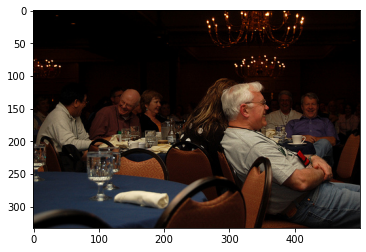

In [100]:
#Below we are testing model on 5 different images

rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> people are dining and laughing <end>
Prediction Caption: people gathered around a restaurant table at a room at a local bar having drinks <end>


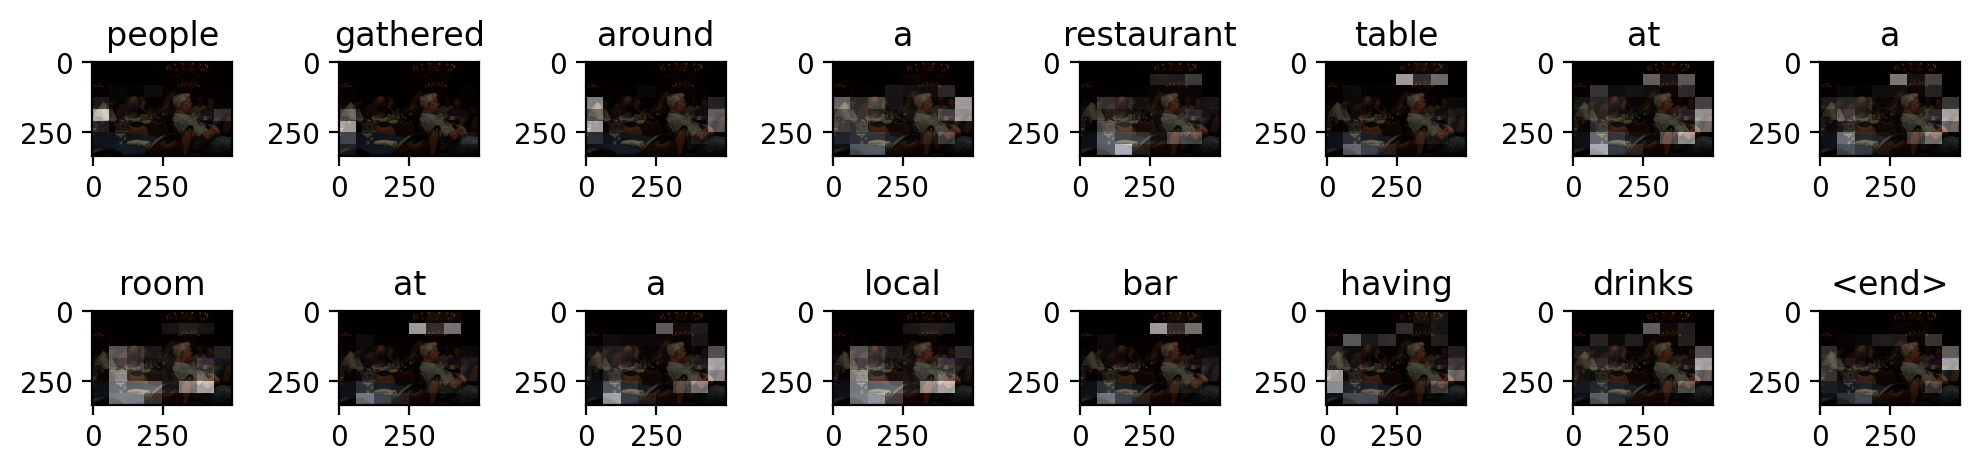

In [110]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True 
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

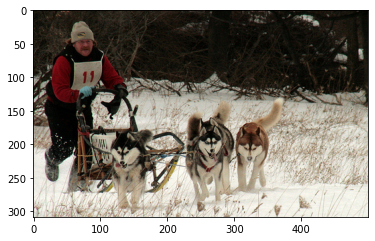

In [63]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> a man rides a sled pulled by a team of dogs <end>
Prediction Caption: three dogs play in the snow <end>


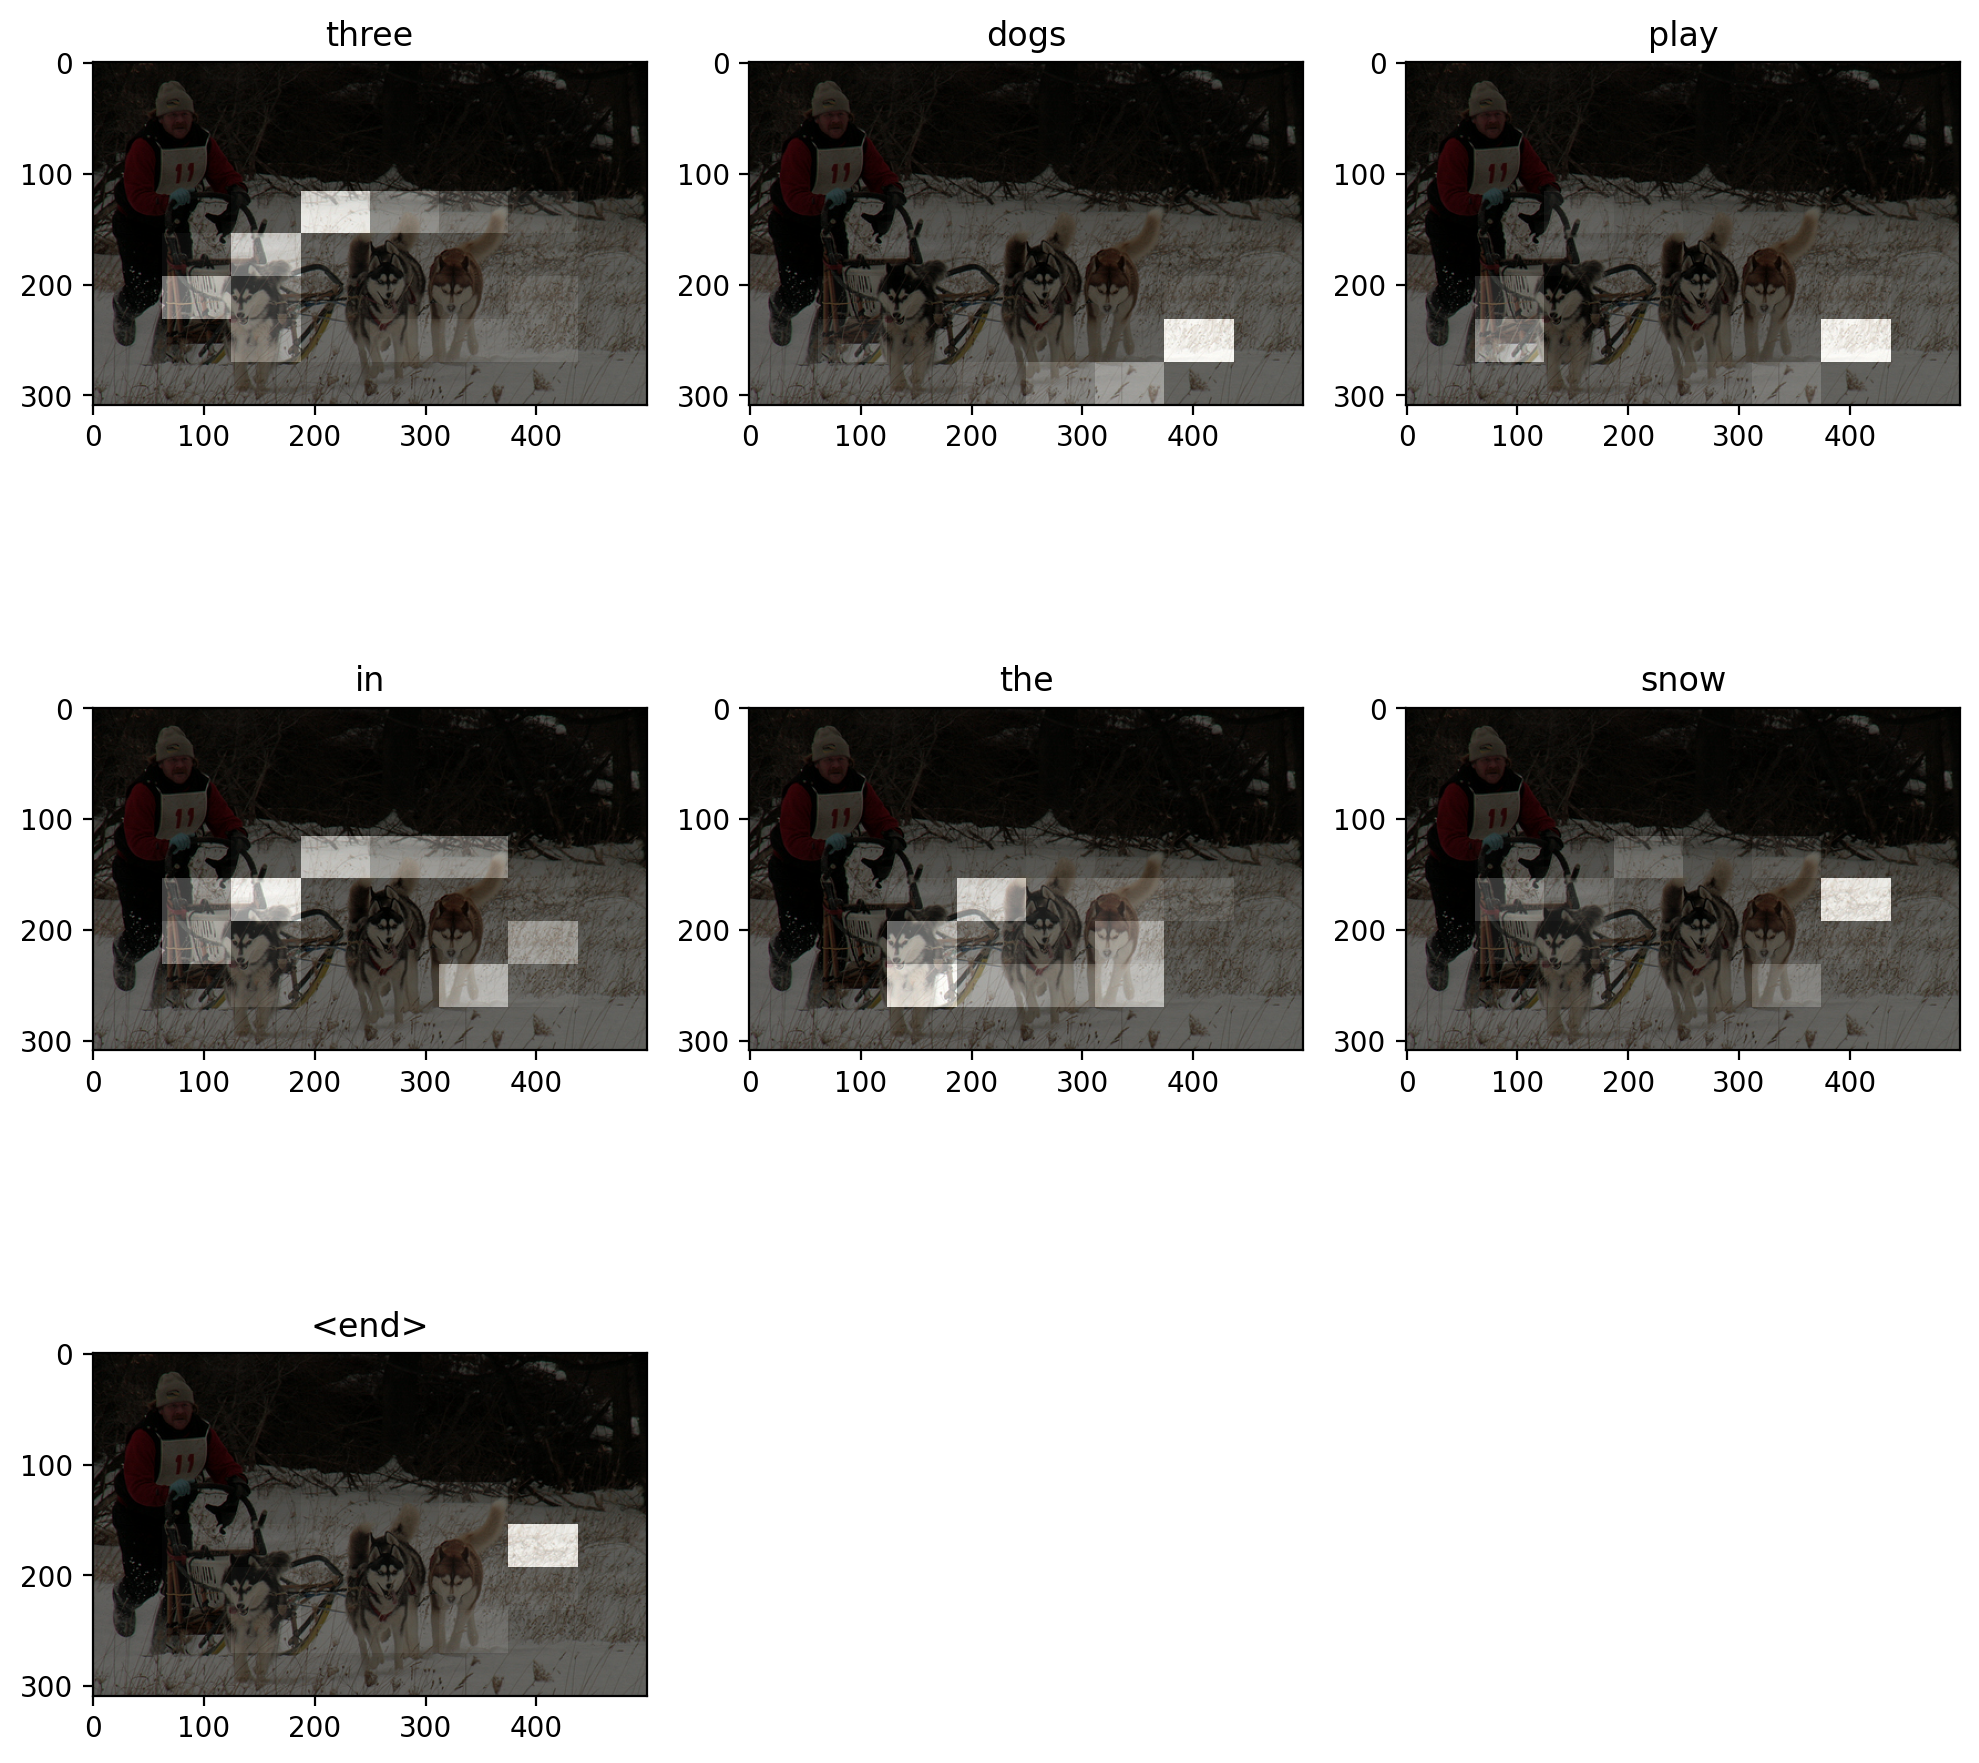

In [65]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True 
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

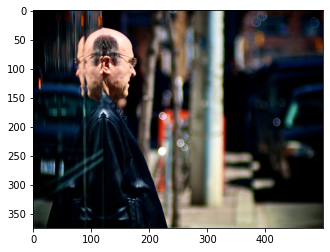

In [58]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> a middle aged man coming out of a bus and talking on the phone <end>
Prediction Caption: an older man in a black leather jacket and tie is on his cellphone <end>


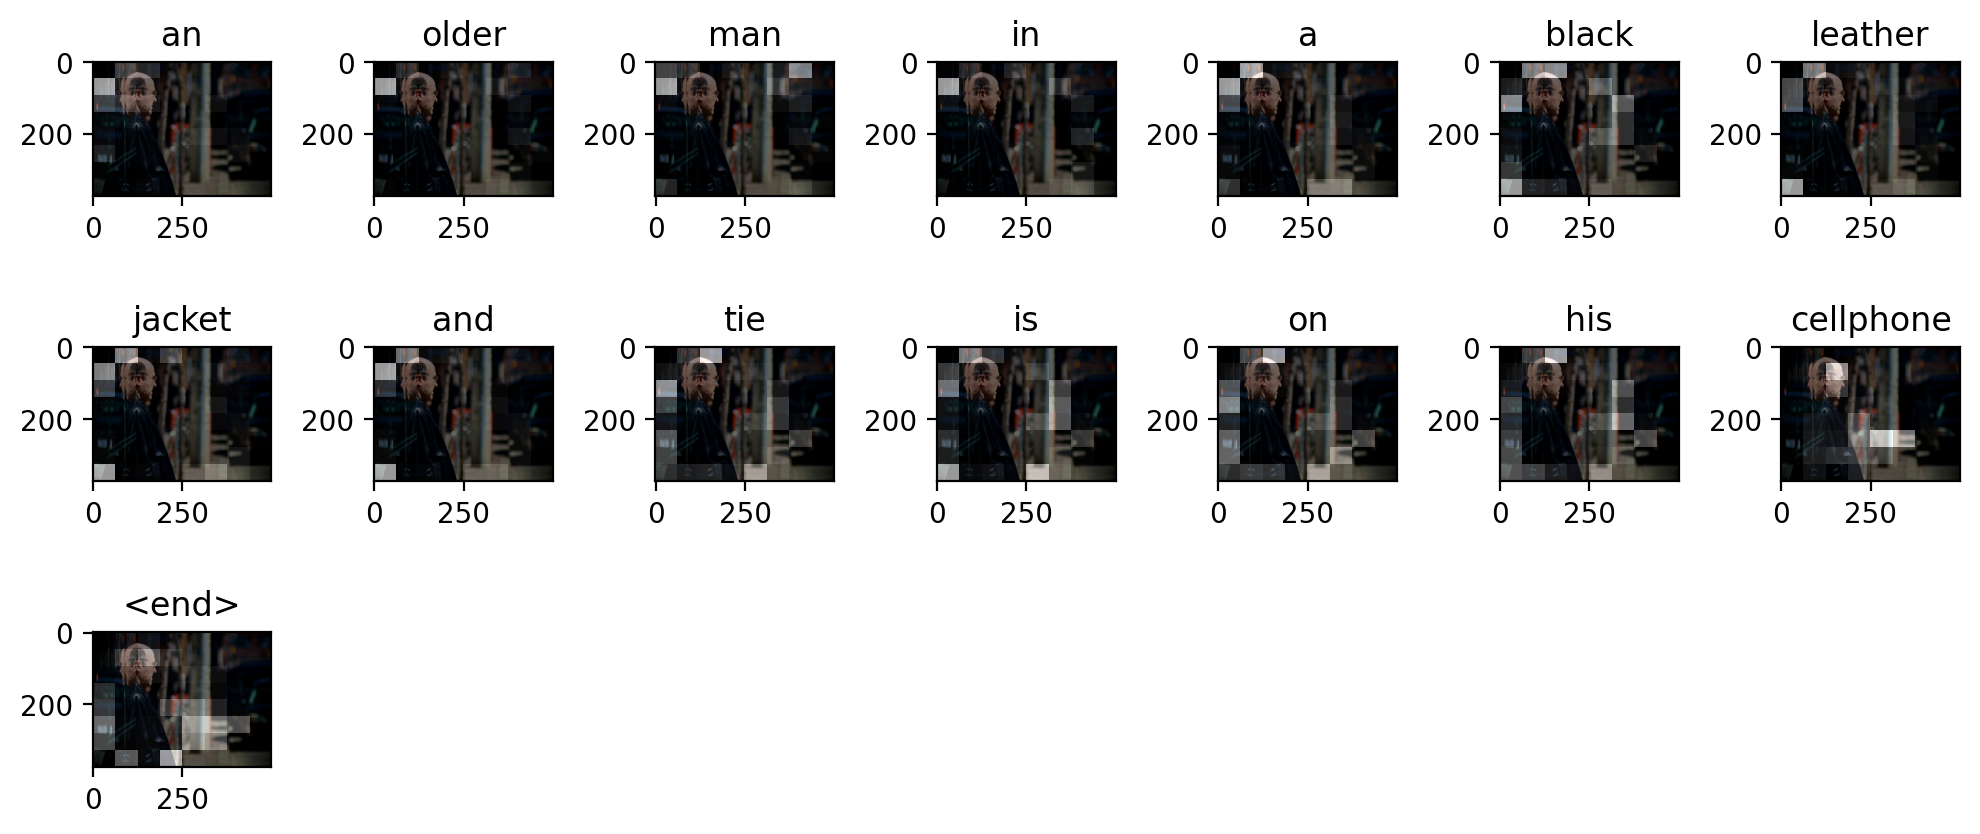

In [62]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True 
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

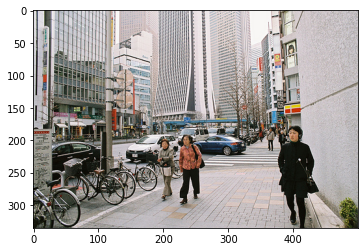

In [126]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> three women two which are elderly walking on a sidewalk <end>
Prediction Caption: two women with a scarf walks in a city <end>


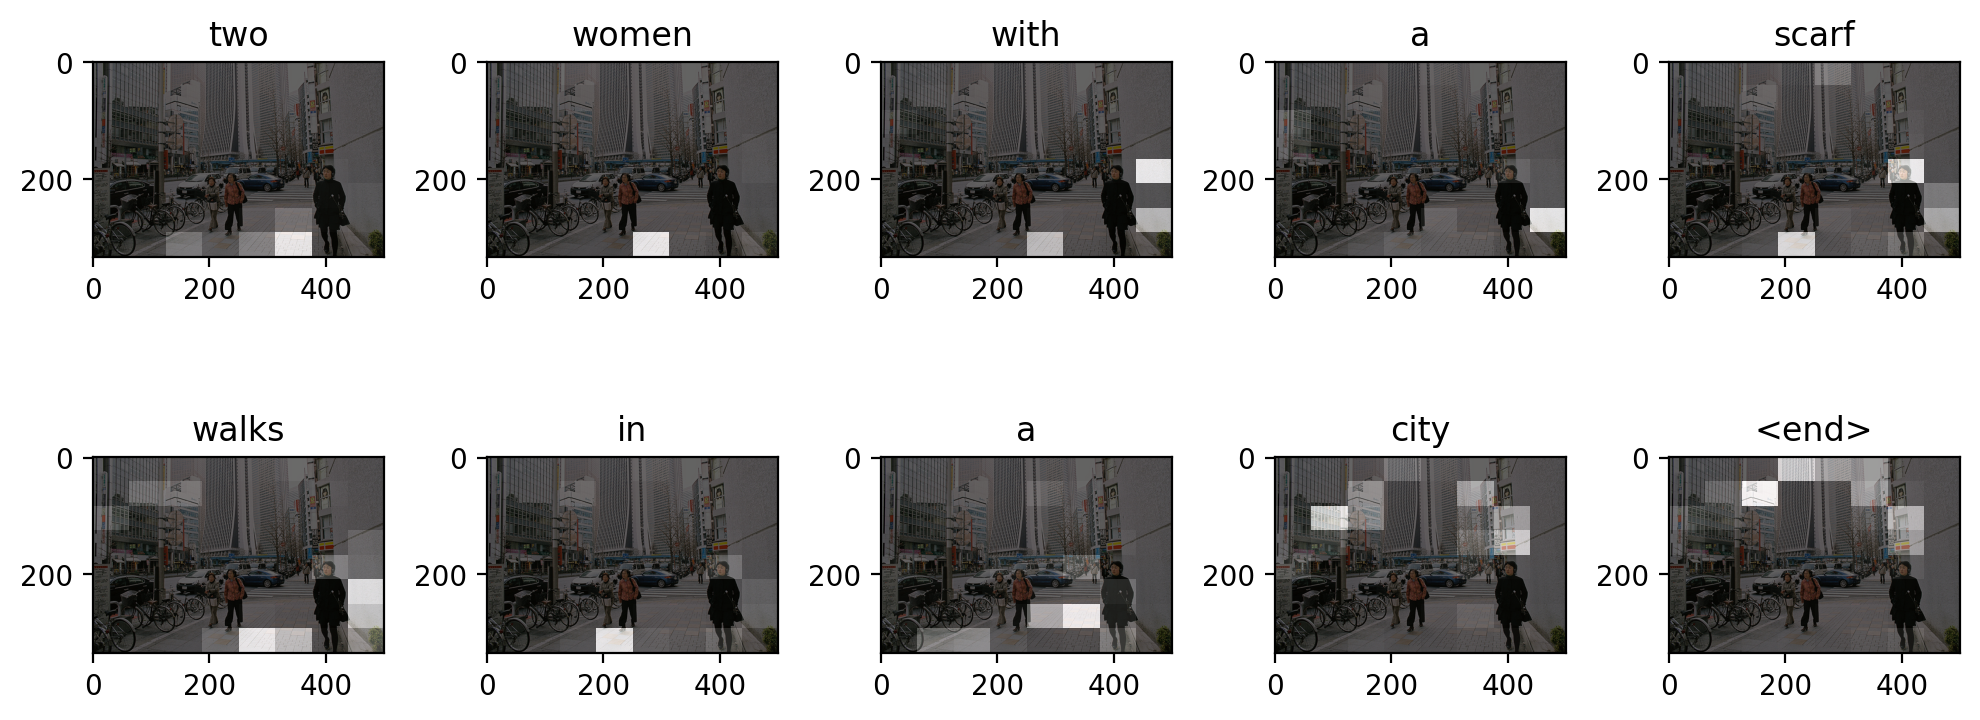

In [129]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True 
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

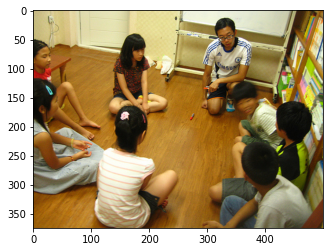

In [140]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> a group of asian children are gathered around in a circle listening to an older male in a white shirt <end>
Prediction Caption: a group of five asian boys are completing class <end>


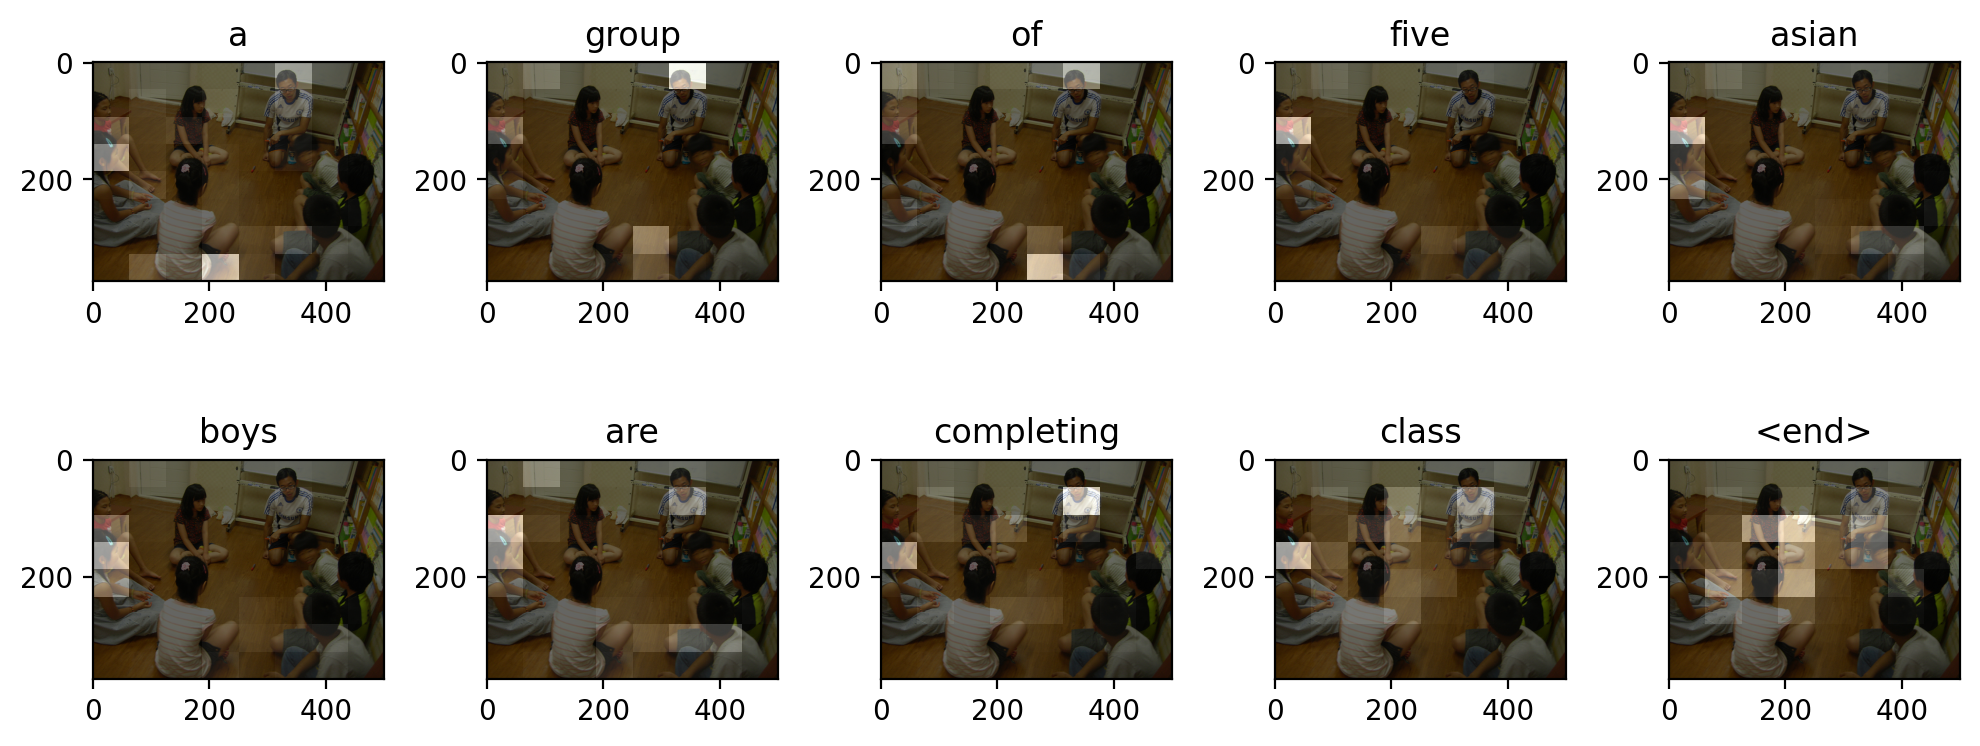

In [146]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True 
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)